In [ ]:
#coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from ncov.reader import get_data,watch_data
import statsmodels.tsa.api as smt    
from statsmodels.tsa.stattools import adfuller
## test:
# get_data('湖北', '武汉', '2020-01-01', '2020-02-08')

In [ ]:
def cal_acc_confirm(I,R,D):
    return I+R+D
def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm
def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

In [ ]:
import torch
from torch.nn.parameter import Parameter
torch.set_default_tensor_type(torch.DoubleTensor)

In [63]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init=0.2586, gamma_2_init=0.018, theta_init=0.001, alpha_init=0.3, omega_init=0.2):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        # self.N = Parameter(torch.tensor([N], requires_grad=False))
        self.N = N
        self.gamma_1 = 0.
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        self.alpha = Parameter(torch.tensor([alpha_init], requires_grad=True))
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        self.omega = Parameter(torch.tensor([omega_init], requires_grad=True))
        # self.omega = 0.


    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def act(self, X):
        # return torch.nn.LeakyReLU(0.1)(X)
        # return torch.relu(X)
        return torch.pow(X, 2)

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = S + self.act(self.omega)*Exposed - self.act(self.beta)*confirm*S/self.N # dS/dt
        E = Exposed + self.act(self.beta)*confirm*S/self.N - (self.act(self.alpha)+self.act(self.omega))*Exposed # dE/dt

        I = confirm + self.act(self.alpha)*Exposed - (self.act(self.gamma_2)+ self.act(self.theta))*confirm # dI/dt
        R = recover + self.act(self.gamma_2)*confirm # dR/dt
        D = dead + self.act(self.theta)*confirm

        # I = confirm + self.act(self.alpha)*E - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        # R = recover + self.act(self.gamma_2)*I # dR/dt
        # D = dead + self.act(self.theta)*I

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.alpha, self.omega, self.N


In [ ]:

class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., I_init=41, R_init=2., D_init=0., E_init=0.):
        super(SEIR_model, self).__init__()
        self.date_len = date_len
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.I = I_init
        self.E = E_init
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len

        for i in range(self.date_len):
            self.SEIR_cells.append(SEIR_cell(self.N))

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, alpha_cur, omega_cur, N = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.alpha = alpha_cur
            self.omega = omega_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            self.N_cur = N
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, param={}):
        if param=={}:
            N_cur=self.N_cur
            beta=self.beta
            gamma_2=self.gamma_2
            theta=self.theta
            alpha=self.alpha
            omega=self.omega
        else:
            N_cur=self.N_cur
            beta=param['beta']
            gamma_2=param['gamma_2']
            theta=param['theta']
            alpha=param['alpha']
            omega=param['omega']

        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur,beta,gamma_2,theta,alpha,omega))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, alpha_, omega_, N_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor
    
    def param_pred(self,beta_list,gamma_2_list,theta_list,alpha_list,omega_list):
        datas=[beta_list,gamma_2_list,theta_list,alpha_list,omega_list]
        params=['beta','gamma_2','theta','alpha','omega']
        param_dict={}
        for i in range(len(params)):
            param=params[i]
            print(param)
            data=datas[i]
            print("pre data:",data)
            if i==0:
                data=data[np.argmax(data):]
                print("data:",data)
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1]
            print(u'差分序列次数为：',dif)
    #         print(u'差分序列的白噪声检验结果为：', acorr_ljungbox(dif_data,lags=1))     
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    print(p,q)
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            print(u'BIC最小的p值和q值为：%s、%s' %(p,q))
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
            model.summary2() #给出一份模型报告
            param_dict[param]=model.forecast(1)[0][0]
            print(param_dict[param])
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
    #             print( dif_data_list[-1])
                for i in range(1,dif+1,1):
                    dif_data_list[-i-1]=np.append(dif_data_list[-i-1],dif_data_list[-i][-1]+ dif_data_list[-i-1][-1])
    #                 print(dif_data_list[-i-1])
                param_dict[param]=dif_data_list[0][-1]
        return param_dict
    
        

In [89]:
def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    # accumulated_confirmed = data[I_name]
    # accumulated_death = data['accumulated_death']
    # accumulated_recovered = data[R_name]
    time_val = data[T_name].values
    
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, accumulated_confirmed, color = 'red', label = '累计确诊人数',marker = 'x')
    plt.plot(merge_time, accumulated_pred_confirmed, color = 'blue',label = '预测的累计确诊人数',marker = 'x')

    error_rate = np.abs(accumulated_pred_confirmed[:len(accumulated_confirmed)]-accumulated_confirmed)/accumulated_confirmed*10000
    plt.plot(time_val, error_rate, color = 'darkorange', label = '错误率',marker = 'x')
    for a,b in zip(time_val, error_rate):   
        plt.annotate('%.2f'%(b/100)+'%',xy=(a,b),xytext=(-5,20), textcoords='offset points',color='darkorange')
    for a,b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [ ]:
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '预测新增确诊人数',marker = 'x')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [ ]:
def plot_SEIRD(data, S, E, I, R, D, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(merge_time, I, color = 'red', label = 'I-感染人数',marker = '.')
    plt.plot(merge_time, R, color = 'blue',label = 'R-治愈人数',marker = '.')
    # plt.plot(merge_time, S, color = 'darkgreen',label = 'S-易感人群',marker = '.')
    # plt.plot(merge_time, E, color = 'darkorange',label = 'E-疑似人数',marker = '.')
    plt.plot(merge_time, D, color = 'black',label = 'D-死亡人数',marker = '.')

    for a,b in zip(merge_time, I):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='red')
    # for a,b in zip(merge_time, S):
    #     plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='darkgreen')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [ ]:
# test_pred=torch.tensor(range(1,5))
# test_gt=torch.tensor(range(2,6))

# loss_fn(test_pred,test_gt)

In [28]:
import torch.optim as optim
import os
def loss_fn(pred, gt, attention_days=3):
    T = list(gt.shape)[0]
    # print(T)
    loss_attention = torch.tensor([0.])
    # if T >=attention_days:
    #     for i in range(T-attention_days,T):
    #         loss_attention = loss_attention + torch.mean(2*torch.pow(pred[i]-gt[i],2))
    loss = torch.nn.MSELoss()(pred,gt) + loss_attention
    return loss
def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path,city)
    
    model_city_date_path = os.path.join(model_city_path,date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def lr_change(step, lr_init=0.01, start_epoch=1500, max_epoches=6000):
    # decay = max_epoches/2.
    lr = lr_init
    if step>start_epoch:
        lr = lr - (step-start_epoch)*lr_init/(max_epoches-start_epoch)
    return lr
    
def lr_decay(global_step,learning_rate=0.01,decay_rate=0.8,decay_steps=300):
    decayed_learning_rate = learning_rate * np.power(decay_rate,(global_step / decay_steps))
    return decayed_learning_rate
    
def train(data, model_city_date_path, N=1e7, I_init=1e-6, R_init=1e-6/2., D_init=1e-6/6., E_init=1e-6, features=['I', 'cured', 'dead', 'E'], max_epoches = 400, lr=0.01, E_loss_ratio=0.002, start_change_lr=1500, start_train_E=0):
    model_pt = os.path.join(model_city_date_path,'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat,dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len,  pred_date_len = 10, N=N, I_init=I_init, R_init=R_init, D_init=D_init, E_init=E_init)
    # Learning rate for optimizers
    lr_init = lr
    # learning_rate = lr_init
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    # I_pred_list = []
    # R_pred_list = []
    # optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    # optimizer = optim.RMSprop(model.parameters(), lr=lr)
    loss_min = 1e9
    loss_list = []
    for epoch_step in range(max_epoches):
        print("Training step: ", epoch_step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S,I,E,R,D, beta,gamma_2 = model(model_inp.float())
        # print(output)
        # loss_fn = torch.nn.MSELoss()
        pred_I = I
        pred_recovered = R
        pred_dead = D
        pred_E = E
        pred_confirm = pred_I+pred_recovered+pred_dead
        # print(pred_confirmed)
        
        I_gt_tensor = Input[:,0]
        recovered_gt_tensor = Input[:,1]
        dead_gt_tensor = Input[:,2]
        E_gt_tensor = Input[:,3]
        confirm_gt = I_gt_tensor+recovered_gt_tensor+dead_gt_tensor
        # loss = torch.sqrt(loss_fn(pred_I, I_gt_tensor) + loss_fn(pred_recovered, recovered_gt_tensor) + loss_fn(pred_dead, dead_gt_tensor) + loss_fn(pred_E, E_gt_tenor))
        loss_C = 0.1*(loss_fn(pred_confirm, confirm_gt) + loss_fn(pred_I, I_gt_tensor) + 4*loss_fn(pred_recovered, recovered_gt_tensor) + 4*loss_fn(pred_dead, dead_gt_tensor))
        loss_E = (loss_fn(pred_E, E_gt_tensor))
        # start_train_E=0
        # if epoch_step>=start_train_E:
        loss = torch.sqrt((1-E_loss_ratio)*loss_C + E_loss_ratio*loss_E)
        print("Loss: {}".format(loss))
        print("loss_C: {}".format(loss_C))
        print("Loss E: {}".format(loss_E))
        loss_list.append(loss)
        if loss<loss_min and epoch_step>=start_train_E:
            loss_min = loss
            torch.save(model, model_pt)
        learning_rate = lr_decay(epoch_step,lr_init,decay_steps=300)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:",loss_min)
    return S,I,E,R,D, loss_list


# model_city_date_path = make_dir('wuhan','02-03')
# features=['accumulated_confirmed', 'accumulated_recovered']
# S,I,E,R,model = train(data_wh_feat, model_city_date_path, N=2870000., I_init=41, R_init=2., features=features, max_epoches=400)

In [ ]:
def train_with_city_data(data, N_init, date, cityname='深圳', features=['I', 'cured','dead','E'], max_epoches=2000, start_train_E=1e9):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    E_init = float(data['E'].iloc[0])
    S,I,E,R,D, loss_list = train(data, model_city_date_path, N=N_init, I_init=I_init, R_init=R_init, D_init=D_init, E_init=E_init, features=features, max_epoches=max_epoches, lr=0.01, E_loss_ratio=0.025, start_train_E=start_train_E)
    # plt
    plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')

    return model_city_date_path

In [ ]:
def load_model_predict(model_city_date_path, data, param_pred=False, city_name='深圳',c='confirmed', features=['I','cured','dead','E'], pred_date_len=5):
    I_name,recover_name,dead_name,E_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    S = model.S_tensor_cur
    E = model.E_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)
    S_pred_old = (S.detach().numpy()).astype(np.int)
    E_pred_old = (E.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)

    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)
    if param_pred:
        beta = []
        gamma_2 = []
        theta = []
        alpha = []
        omega = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
            omega.append(model.SEIR_cells[i].theta.detach().numpy()[0])

        param = model.param_pred(beta,gamma_2,theta,alpha,omega)
        print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len, param=param)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)
    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    S_pred_new = (S_pred_tensor.detach().numpy()).astype(np.int)
    E_pred_new = (E_pred_tensor.detach().numpy()).astype(np.int)

    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)
    S_pred_total = np.concatenate((S_pred_old,S_pred_new),axis=0)
    E_pred_total = np.concatenate((E_pred_old,E_pred_new),axis=0)


    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)

    print(confirm_pred)
    
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)
    plot_SEIRD(data, S_pred_total,E_pred_total,I_pred_total,R_pred_total,D_pred_total,city=city_name, pred_date_len=pred_date_len)
    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total

    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

In [ ]:
def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    # data['time'] = data['time'].apply(lambda x:x-np.timedelta64(1,'D'))
    return data

In [91]:
# data_china = pd.read_excel('./ncov/data/nation_data.xlsx')
data_china = read_data('./ncov/data/nation_截至0209_24时.csv')
data_china

,confirmed,new_confirmed,suspected,new_suspected,dead,new_death,cured,new_cured,close_contact,under_medical_observation,quit_medical_observation,time,I,E
0,291,77,54,27,6,6,0,0,1739,922,817,2020-01-20,285,2715
1,440,149,136,82,9,3,0,0,2197,1349,848,2020-01-21,431,3682
2,571,131,393,257,17,8,0,0,5897,4928,969,2020-01-22,554,11218
3,830,259,1072,680,25,8,34,6,9507,8420,1087,2020-01-23,771,18999
4,1287,444,1965,1118,41,16,38,3,15197,13967,1230,2020-01-24,1208,31129
5,1975,688,2684,1309,56,15,49,11,23431,21556,1875,2020-01-25,1870,47671
6,2744,769,5794,3806,80,24,51,2,32799,30453,2346,2020-01-26,2613,69046
7,4515,1771,6973,2077,106,26,60,9,47833,44132,3701,2020-01-27,4349,98938
8,5974,1459,9239,3248,132,26,103,43,65537,59990,5547,2020-01-28,5739,134766
9,7711,1737,12167,4148,170,38,124,21,88693,81947,6746,2020-01-29,7417,182807


In [92]:
# # data_china['time'] = data_china['time'].apply(lambda x: '2020/'+x.replace('月','/').replace('日',''))
# data_china['time'] = pd.to_datetime(data_china['time'])
# data_china['time']

In [93]:
# data_china['E']=data_china['suspected']+data_china['close_contact']+data_china['under_medical_observation']
# data_china['E']

In [94]:
def train_with_city_data(data, N_init, date, cityname='深圳', features=['I', 'cured','dead','E'], start_change_lr=2000, max_epoches=2000, start_train_E=0):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    E_init = float(data['E'].iloc[0])
    S,I,E,R,D, loss_list = train(data, model_city_date_path, N=N_init, I_init=I_init, R_init=R_init, D_init=D_init, E_init=E_init, features=features, max_epoches=max_epoches, lr=0.01, E_loss_ratio=0.025, start_change_lr=2000, start_train_E=start_train_E)
    # plt
    plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')

    return model_city_date_path

grad_fn=<MulBackward0>)
Loss E: tensor([3.1472e+08], grad_fn=<AddBackward0>)
Training step:  9889
Loss: tensor([3230.7435], grad_fn=<SqrtBackward>)
loss_C: tensor([2635885.2215], grad_fn=<MulBackward0>)
Loss E: tensor([3.1471e+08], grad_fn=<AddBackward0>)
Training step:  9890
Loss: tensor([3230.7161], grad_fn=<SqrtBackward>)
loss_C: tensor([2635905.4253], grad_fn=<MulBackward0>)
Loss E: tensor([3.1470e+08], grad_fn=<AddBackward0>)
Training step:  9891
Loss: tensor([3230.6890], grad_fn=<SqrtBackward>)
loss_C: tensor([2635914.1943], grad_fn=<MulBackward0>)
Loss E: tensor([3.1469e+08], grad_fn=<AddBackward0>)
Training step:  9892
Loss: tensor([3230.6617], grad_fn=<SqrtBackward>)
loss_C: tensor([2635934.3567], grad_fn=<MulBackward0>)
Loss E: tensor([3.1469e+08], grad_fn=<AddBackward0>)
Training step:  9893
Loss: tensor([3230.6345], grad_fn=<SqrtBackward>)
loss_C: tensor([2635956.6526], grad_fn=<MulBackward0>)
Loss E: tensor([3.1468e+08], grad_fn=<AddBackward0>)
Training step:  9894
Loss: t

'models/china/tmp'

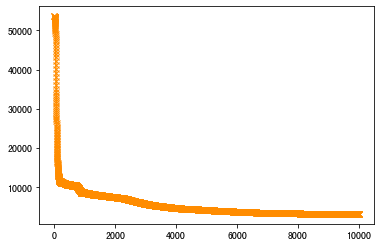

In [95]:
N_init = (max(data_china['E'])+max(data_china['I'])+max(data_china['cured'])+max(data_china['dead']))*100.
date = 'tmp'
cityname='全国'
train_with_city_data(data_china,N_init,date,cityname,max_epoches=10000,start_change_lr=1500, start_train_E=0)

In [96]:
model_city_date_path='models/china/tmp'
model_pt = os.path.join(model_city_date_path,'model.pt')
model = torch.load(model_pt)
model.I_tensor_cur

tensor([  285.0000,  2566.5316,  3079.9930,  4683.0800,  6823.2832,  9408.2334,
        11006.8334, 11015.2166, 10751.0462, 10751.0462, 10751.0462, 11398.0133,
        13443.3561, 16244.3050, 19335.1883, 22924.7162, 26304.7571, 28995.8284,
        31772.1062, 33733.9082, 35979.7128], requires_grad=True)

In [97]:
model.E_tensor_cur

tensor([  2715.0000,    675.0273,   2407.4817,   3633.4828,   6034.8369,
         11411.5281,  23669.1443,  51749.4293, 140363.9580, 184187.1782,
        232467.0218, 271726.3860, 320105.3791, 363852.8442, 415558.7048,
        460983.4672, 493888.7754, 526492.0845, 562793.8223, 589005.7674,
        610580.2730], requires_grad=True)

In [98]:
model.S_tensor_cur

tensor([65073494.0000, 65073252.4411, 65071006.5253, 65068177.4371,
        65063635.8799, 65055674.2385, 65041818.0222, 65013102.0807,
        64924487.5520, 64880664.3317, 64832384.4881, 64792478.1569,
        64742053.5555, 64695473.3232, 64640498.8159, 64591172.1442,
        64554594.6626, 64518825.8821, 64479169.7193, 64450300.0708,
        64425751.1044], requires_grad=True)

In [99]:
model.R_tensor_cur

tensor([0.0000e+00, 1.3602e-11, 8.8109e-08, 8.8111e-08, 8.8113e-08, 8.8118e-08,
        3.5455e-07, 3.1464e+02, 4.4876e+02, 4.4876e+02, 4.4876e+02, 4.4876e+02,
        4.4903e+02, 4.7843e+02, 6.3891e+02, 9.1550e+02, 1.1446e+03, 1.5408e+03,
        2.0482e+03, 2.6480e+03, 3.2812e+03], requires_grad=True)

In [100]:
model.D_tensor_cur

tensor([  6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,   6.0000,
        318.6380, 448.6823, 448.6823, 448.6823, 448.6823, 448.6823, 451.0979,
        468.3853, 504.1706, 567.1680, 645.4385, 716.1506, 812.2370, 907.6968],
       requires_grad=True)

beta: [0.8476142860700617, 0.8751218491860026, 0.9186147545330253, 0.9699040066367028, 1.167065080639821, 1.4732470387186667, 2.61031056990694, 8.120267157532766, 4.521055507212047, 4.504265943501092, 3.7258319747687976, 4.4433744361256915, 3.482892736998157, 3.404641498558012, 2.5701353150325414, 1.6172498335705447, 1.3907477063801779, 1.3837173805677347, 0.9451608758614046, 0.7708214489439941]
gamma_2: [4.772764534292527e-14, 3.432479054655442e-11, 6.940943790594957e-16, 4.2765232025663345e-16, 6.443772008233248e-16, 2.8319308497516827e-11, 0.028585467515767432, 0.012176434824247804, 9.022837954790523e-15, 3.351540560723054e-11, 2.288341879615072e-14, 2.329250634610073e-05, 0.0021871513789122805, 0.009878908338703403, 0.014305324318143802, 0.009995113343153242, 0.015059232212885626, 0.01750028440723762, 0.01887866781239999, 0.018770320090992134]
theta: [4.790902573092515e-14, 7.887327036614844e-16, 6.964848786229958e-16, 4.3049426132547574e-16, 3.4356435686004206e-11, 3.2346323815285

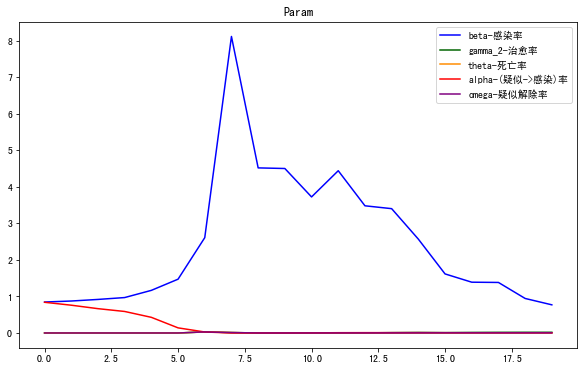

In [101]:
beta = []
gamma_2 = []
theta = []
alpha = []
omega = []
for i in range(len(model.SEIR_cells)):
    beta.append(np.square(model.SEIR_cells[i].beta.detach().numpy()[0]))
    gamma_2.append(np.square(model.SEIR_cells[i].gamma_2.detach().numpy()[0]))
    theta.append(np.square(model.SEIR_cells[i].theta.detach().numpy()[0]))
    alpha.append(np.square(model.SEIR_cells[i].alpha.detach().numpy()[0]))
    omega.append(np.square(model.SEIR_cells[i].theta.detach().numpy()[0]))

print('beta:',beta)
print('gamma_2:',gamma_2)
print('theta:',theta)
print('alpha:',alpha)
print('omega:',omega)
plot_title = ['beta-感染率','gamma_2-治愈率','theta-死亡率','alpha-(疑似->感染)率','omega-疑似解除率']
plot_list = [beta,gamma_2,theta,alpha,omega]
colors=['blue','darkgreen','darkorange','red','purple']
plt.figure(figsize=(10,6))
for i in range(len(colors)):
    plt.plot(plot_list[i],color=colors[i],label=plot_title[i])
plt.legend()
plt.title('Param')
plt.show()

[  291   440   571   830  1287  1975  2744  4515  5974  7711  9692 11791
 14380 17205 20438 24324 28018 31161 34546 37198 40171]


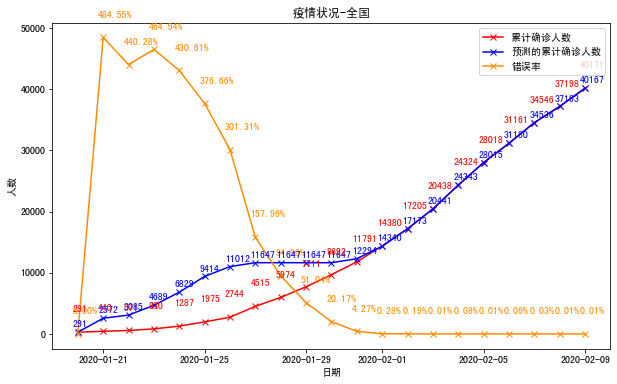

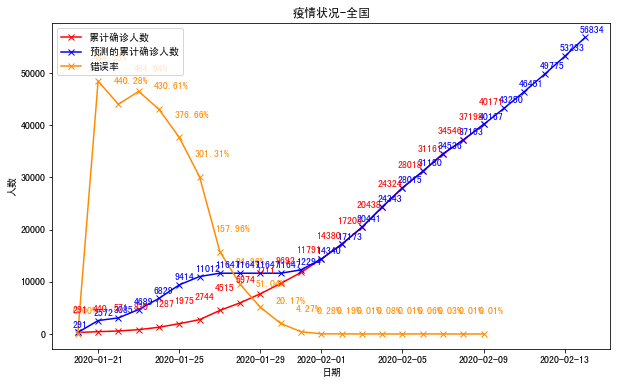

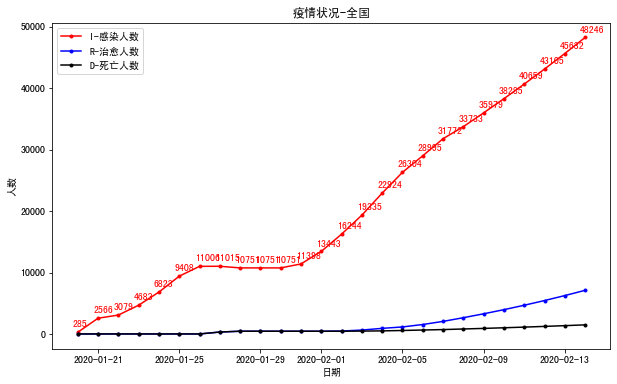

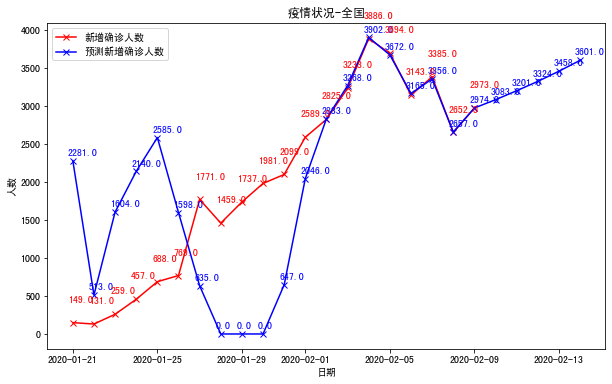

In [102]:
features=['I', 'cured', 'dead','E']
load_model_predict(model_city_date_path, data_china, city_name='全国', features=features)

In [77]:
data_china[['time','E']]

,time,E
0,2020-01-20,2715
1,2020-01-21,3682
2,2020-01-22,11218
3,2020-01-23,18999
4,2020-01-24,31129
5,2020-01-25,47671
6,2020-01-26,69046
7,2020-01-27,98938
8,2020-01-28,134766
9,2020-01-29,182807


In [ ]:
# def param_pred(beta_list):
#         datas=[beta_list]
#         params=['beta']
#         param_dict={}
#         for i in range(len(params)):
#             param=params[i]
#             data=datas[i]
#             if i==0:
#                 data=data[np.argmax(data):]
#             data_copy=pd.DataFrame(data,columns=[param])
#             dif_data=data_copy
#             dif_data_list=[data_copy.values]
#             dif=0
#             p_value = adfuller(data_copy[param])[1]
#             while p_value>0.05:
#                 dif=dif+1
#                 dif_data=dif_data.diff(1).dropna()
#     #             print(dif_data)
#                 dif_data_list.append(dif_data.values)
#                 p_value= adfuller(dif_data[param])[1]
#             print(u'差分序列次数为：',dif)
#     #         print(u'差分序列的白噪声检验结果为：', acorr_ljungbox(dif_data,lags=1))     
#             pmax = int(len(data)/10) 
#             qmax = int(len(data)/10)
#             if dif>1:
#                 d=0
#                 data=dif_data
#             else:
#                 d=dif
#             bic_matrix = [] #bic矩阵
#             for p in range(pmax+1):
#                 tmp = []
#                 for q in range(qmax+1):
#                     print(p,q)
#                     try: #存在部分报错，所以用try来跳过报错。
#                         tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
#                     except:
#                         tmp.append(None)
#                 bic_matrix.append(tmp)
#             bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
#             p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
#             print(u'BIC最小的p值和q值为：%s、%s' %(p,q))
            
#             model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
#             model.summary2() #给出一份模型报告
#             param_dict[param]=model.forecast(1)[0][0]
#             print(param_dict[param])
#             if dif>1:
#                 dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
#     #             print( dif_data_list[-1])

# beta=[0.40502478547952564, 0.3904928623935576, 0.3939955351112145, 0.3802507124652505, 0.370769942023456, 0.37010285438191143, 0.3882072866519215, 0.4758306622778919, 0.4833769060816163, 0.47670619301613126, 0.4588695029852291, 0.4304954489104633, 0.40791392665214193, 0.38815426552789345, 0.4211287060577203, 0.500763107670777, 0.4402490503219537, 0.015015719829420859, -1.0255316799423018, -1.902741315209042]
# param_pred(beta)

In [ ]:
def read_hubei_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['E']=data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    # data['time'] = data['time'].apply(lambda x:x-np.timedelta64(1,'D'))
    return data

In [ ]:
data_hubei = read_data('./ncov/data/hubei_截至0209_24时i.csv')
data_hubei

In [ ]:
data_hubei['E']

In [ ]:
N_init = (max(data_hubei['E'])+max(data_hubei['I'])+max(data_hubei['cured'])+max(data_hubei['dead']))*10000.
date = 'yisi02-10'
cityname='湖北'
# S_china,I_china,E_china,R_china,D_china = train(data_hubei, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)
train_with_city_data(data_hubei,N_init,date,cityname,max_epoches=6000,start_train_E=0)

In [ ]:
model_city_date_path='models/hubei/yisi02-10'
model_pt = os.path.join(model_city_date_path,'model.pt')
model = torch.load(model_pt)
model.I_tensor_cur

In [ ]:
features=['I', 'cured', 'dead','E']
load_model_predict(model_city_date_path, data_hubei, city_name='湖北', features=features)

In [ ]:
# def load_model_predict(model_city_date_path, data, N_cur,beta,gamma_2,theta, city_name='深圳',c='confirmed', features=['I','cured','dead','E'], pred_date_len=5):
#     I_name,recover_name,dead_name,E_name = features
#     model_pt = os.path.join(model_city_date_path,'model.pt')
#     model = torch.load(model_pt)
#     I = model.I_tensor_cur
#     R = model.R_tensor_cur
#     D = model.D_tensor_cur
#     I_pred_old = (I.detach().numpy()).astype(np.int)
#     R_pred_old = (R.detach().numpy()).astype(np.int)
#     D_pred_old = (D.detach().numpy()).astype(np.int)

#     confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     print(confirm_origin)
#     # plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)

#     new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
#     print("new_confirm:",new_confirm)
#     cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)
#     print("new_confirm_pred:",new_confirm_pred)


#     # print(I_pred_old+R_pred_old+D_pred_old)

#     S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(N_cur=N_cur,beta=beta,gamma_2=gamma_2,theta=theta, pred_date_len = pred_date_len)
#     I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
#     R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
#     D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
#     I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
#     R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
#     D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

#     confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)
#     print("confirm_pred:",confirm_pred)
#     new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
#     new_confirm_pred_total

#     plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)
# load_model_predict(model_city_date_path, data_china, N_cur=param['N'],beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'], city_name='全国', features=features, pred_date_len=30)

In [ ]:
merge_data = pd.read_csv('./ncov/data/nation/allcity_20200209.csv')
merge_data = merge_data.rename(columns = {'updatetime':'time'})
merge_data['time'] = merge_data['time'].apply(lambda x: '2020/'+x)
merge_data['time']

In [ ]:
merge_data['I'] = merge_data['confirmed']-merge_data['dead']-merge_data['cured']
merge_data['I']

In [ ]:
merge_data['time']= pd.to_datetime(merge_data['time'])
merge_data['time']

In [ ]:
data_sz = merge_data[merge_data.cityname=='深圳']
data_sz

In [ ]:
def cal_acc_confirm(I,R,D):
    return I+R+D
def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm
def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

In [ ]:
model_city_date_path = make_dir('shenzhen','02-08')
features=['I', 'cured','dead']
I_init = float(data_sz['I'].iloc[0])
R_init = float(data_sz['cured'].iloc[0])
D_init = float(data_sz['dead'].iloc[0])
N = 13026600.
S,I,E,R,D = train(data_sz, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

In [ ]:
# def load_model_predict(model_city_date_path, data, city_name='深圳',c='confirmed'):
#     model_pt = os.path.join(model_city_date_path,'model.pt')
#     model = torch.load(model_pt)
#     I = model.I_tensor_cur
#     R = model.R_tensor_cur
#     D = model.D_tensor_cur
#     I_pred_old = (I.detach().numpy()).astype(np.int)
#     R_pred_old = (R.detach().numpy()).astype(np.int)
#     D_pred_old = (D.detach().numpy()).astype(np.int)

#     confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     print(confirm_origin)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


#     new_confirm = cal_new_confirm(np.array(data['I']),np.array(data['cured']),np.array(data['dead']))
#     cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

#     S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = 5)
#     I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
#     R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
#     D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
#     I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
#     R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
#     D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

#     confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=5)

#     new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
#     new_confirm_pred_total

#     plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=5)

In [ ]:
model_city_date_path = 'models/shenzhen/02-08'

In [ ]:
param = {'beta_model_0': 0.022657147212237192, 'gamma_2_model_0': 0.046245946644636965, 'N_model_0': 13026600.144694937, 'theta_model_0': 0.0017369414764662925}

In [ ]:
load_model_predict(model_city_date_path, data_sz,N_cur=param['N_model_0'],beta=param['beta_model_0'],gamma_2=param['gamma_2_model_0'],theta=param['theta_model_0'], city_name='深圳')

In [ ]:
data_wh = merge_data[merge_data.cityname=='武汉']

In [ ]:
model_city_date_path = make_dir('wuhan','02-08')
features=['I', 'cured','dead']
I_init = float(data_wh['I'].iloc[0])
R_init = float(data_wh['cured'].iloc[0])
D_init = float(data_wh['dead'].iloc[0])
N = 2870000.
S,I,E,R,D = train(data_wh, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

In [ ]:
model_city_date_path='models/wuhan/02-08'

In [ ]:
param = {'beta_model_1': 0.039265121494126254, 'gamma_2_model_1': 0.012185829495883437, 'N_model_1': 2870000.1178264813, 'theta_model_1': 0.029595901217760776}

In [ ]:
load_model_predict(model_city_date_path, data_wh, N_cur=param['N_model_1'],beta=param['beta_model_1'],gamma_2=param['gamma_2_model_1'],theta=param['theta_model_1'], city_name='武汉')

In [ ]:
param = {'beta_model_2': 0.03808052845960208, 'gamma_2_model_2': 0.011726751251695009, 'N_model_2': 59170000.21805534, 'theta_model_2': 0.003805129170338665}
i=2
for k in list(param.keys()):
    old_key = k
    new_key = k.replace(f'_model_{i}','')
    param[new_key]=param.pop(old_key)
param

In [ ]:
def train_with_city_data(data, N, date, cityname='深圳',max_epoches=2000):
    # if param=={}:
    #     param['N']=0
    #     N_cur=param['N']
    # else:
    #     N_cur=param['N']
    #     beta=param['beta']
    #     gamma_2=param['gamma_2']
    #     theta=param['theta']
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    S,I,E,R,D = train(data, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=max_epoches)
    return model_city_date_path

In [ ]:
data_hubei = merge_data[(merge_data.provincename=='湖北')&(merge_data.cityname=='全省')]
data_hubei

In [ ]:
param = {'beta_model_2': 0.03808052845960208, 'gamma_2_model_2': 0.011726751251695009, 'N_model_2': 59170000.21805534, 'theta_model_2': 0.003805129170338665}


In [ ]:
model_city_date_path = train_with_city_data(data_hubei,59170000.,'02-08','湖北')

In [ ]:
load_model_predict(model_city_date_path, data_hubei, N_cur=param['N'],beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'], city_name='湖北')

In [ ]:
model_city_date_paths = ['models/shenzhen/02-08','models/wuhan/02-08','models/hubei/02-08','models/china/02-08']

In [ ]:
for model_i in range(len(model_city_date_paths)):
    print(model_city_date_paths[model_i]+':{')
    model_city_date_path = model_city_date_paths[model_i]
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    beta = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
    print(f'beta_model_{model_i}:{beta}')
    gamma_2 = []
    for i in range(len(model.SEIR_cells)):
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
    print(f'gamma_2_model_{model_i}:{gamma_2}')
    N = []
    for i in range(len(model.SEIR_cells)):
        N.append(model.SEIR_cells[i].N.detach().numpy()[0])
    print(f'N_model_{model_i}:{N}')    
    theta = []
    for i in range(len(model.SEIR_cells)):
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
    print(f'theta_model_{model_i}:{theta}')  
    print('}')

In [ ]:
len(model.SEIR_cells)

In [ ]:
beta_sz = []
for i in range(len(model.SEIR_cells)):
    beta_sz.append(model.SEIR_cells[i].beta.detach().numpy()[0])
beta_sz

In [ ]:
np.square(2)